# About skip-thought vectors
Article: http://arxiv.org/abs/1506.06726 

Code : https://github.com/ryankiros/skip-thoughts

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import skipthoughts
from bhtsne import bhtsne as bh
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from os import listdir, walk
import mpld3
mpld3.enable_notebook()
from os.path import isfile, join
from gensim.models import Word2Vec
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords

Using gpu device 0: GRID K520 (CNMeM is disabled)
/home/ubuntu/venv/local/lib/python2.7/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)


In [2]:
# st_model will contain the pretrained weights for the encoder, and the word vectors
st_model = skipthoughts.load_model() 
w2v = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


/home/ubuntu/venv/src/theano/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


## Sentence classification

First of all, we will extract skip-thought sentence representation, and compare it with vanilla sum of word2vecs. 

Dataset : https://archive.ics.uci.edu/ml/datasets/Sentence+Classification

In [3]:
path = '/mnt/data/skip-thoughts/SentenceCorpus/unlabeled_articles'
filepaths = []
for (dirpath, dirnames, filenames) in walk(path):
    for name in filenames:
        if name[-4:] == '.txt':
            filepaths = filepaths+ [join(dirpath, name)]
            
labelmap = {'arxiv_unlabeled':0,
            'jdm_unlabeled':1,
            'plos_unlabeled':2
           }            
labels = []
sentences = []
for fpath in filepaths:
    with open(fpath, 'r') as f:
        label = np.zeros((3,))
        label[labelmap[fpath.split('/')[-2]]] = 1
        filesentences = []
        for s in f.read().split('\n'):
            if len(s.split(' '))>3: #Let us not keep short sentences
                try:
                    #The dataset contains some shitty data due to mistakes in extraction 
                    filesentences += [u'{}'.format(s)] 
                except:
                    continue
        L = len(filesentences)
        labels += L*[label]
        sentences += filesentences
sentences = np.array(sentences)
labels = np.array(labels)

We'll keep only n_sents random elements, but we could keep them all if we had time and RAM. The more sentences we have, the better our t-SNE will be...

In [4]:
n_sents = 2000
np.random.seed(1234)
indexes = np.arange(len(sentences))
np.random.shuffle(indexes)
sentences = sentences[indexes[:n_sents]]
labels = labels[indexes[:n_sents]]
print sentences.shape,labels.shape

(2000,) (2000, 3)


In stop_sentences are listed all the sentences removing the stopwords

In [5]:
stop = stopwords.words('english')
stop_sentences = []
for sent in sentences:
    stop_sent = [w for w in nltk.tokenize.word_tokenize(sent) if w not in stop]
    stop_sentences.append(' '.join(stop_sent))

In [6]:
all_words = list(set([w for s in sentences for w in nltk.tokenize.word_tokenize(s)]))
stop_all_words = list(set([w for s in sentences for w in nltk.tokenize.word_tokenize(s)]))

TFIDF for corpus when we keep the entire sentence

In [7]:
vectorizer = TfidfVectorizer(min_df=0., max_df=1., lowercase=False, tokenizer=nltk.tokenize.word_tokenize)
X = vectorizer.fit_transform(sentences)
idf = vectorizer.idf_
idf = dict(zip(vectorizer.get_feature_names(), idf))
print len(vectorizer.get_feature_names())
sent_tfidf = []
for doc in sentences:
    sent = nltk.tokenize.word_tokenize(doc)
    tf = Counter(sent)
    for k,v in tf.items():
        tf[k] = idf[k]*v/len(sent)
    sent_tfidf.append(tf)

7544


TFIDF for corpus when we remove stopwords

In [8]:
vectorizer = TfidfVectorizer(min_df=0., max_df=1., lowercase=False, tokenizer=nltk.tokenize.word_tokenize)
X = vectorizer.fit_transform(stop_sentences)
idf = vectorizer.idf_
idf = dict(zip(vectorizer.get_feature_names(), idf))
print len(vectorizer.get_feature_names())
stop_sent_tfidf = []
for doc in stop_sentences:
    sent = nltk.tokenize.word_tokenize(doc)
    tf = Counter(sent)
    for k,v in tf.items():
        tf[k] = idf[k]*v/len(sent)
    stop_sent_tfidf.append(tf)

7431


### Combination of Word2Vec
Here we compute four representations : 
- w2v_vectors : sum of word2vec on the whole sentence
- tfidf_w2v_vectors : tfidf-weighted sum of word2vec on the whole sentence
- stop_w2v_vectors : sum of word2vec on the stopwords-free sentence 
- stop_tfidf_w2v_vectors : tfidf-weighted sum of word2vec on the stopwords-free sentence 

In [9]:
w2v_vectors = []
stop_w2v_vectors = []
tfidf_w2v_vectors = []
stop_tfidf_w2v_vectors = []

for sent,stop_sent, tfidf, stop_tfidf in zip(sentences, stop_sentences, sent_tfidf, stop_sent_tfidf):
    words = nltk.word_tokenize(sent)
    stop_words = nltk.word_tokenize(sent)
    vec = np.zeros((300,))
    stop_vec = np.zeros((300,))
    tfidf_vec = np.zeros((300,))
    stop_tfidf_vec = np.zeros((300,))
    for w in words:
        try:
            vec += w2v[w]
            tfidf_vec += tfidf[w]*vec
        except:
            continue
    for w in stop_words:
        try:
            stop_vec += w2v[w]
            stop_tfidf_vec += stop_tfidf[w]*stop_vec
        except:
            continue
    w2v_vectors += [stop_vec]
    stop_w2v_vectors += [vec]
    tfidf_w2v_vectors += [tfidf_vec]
    stop_tfidf_w2v_vectors += [stop_tfidf_vec]
w2v_vectors = np.array(w2v_vectors)
tfidf_w2v_vectors = np.array(tfidf_w2v_vectors)
stop_w2v_vectors = np.array(stop_w2v_vectors)
stop_tfidf_w2v_vectors = np.array(stop_tfidf_w2v_vectors)

print len(sentences), w2v_vectors.shape, tfidf_w2v_vectors.shape, stop_w2v_vectors.shape, stop_tfidf_w2v_vectors.shape
del w2v

2000 (2000, 300) (2000, 300) (2000, 300) (2000, 300)


### Skip-thought
Each sentence is represented by its skip-thought vector. We will have two models :
- st_vectors uses the whole sentence
- stop_st_vectors uses the stopwords-free sentence

In [10]:
stop_st_vectors = skipthoughts.encode(st_model, stop_sentences, verbose=False)
st_vectors = skipthoughts.encode(st_model, sentences, verbose=False)
del st_model

## VISUALIZATION

Then, we compute the t-SNE vectors for each representation.

In [36]:
def compute_tsne(vectors):
    tsne = bh.bh_tsne(samples=vectors)
    tsne = list(tsne)
    return np.array(tsne)

def plot_tsne(tsne, stop_tsne=None, title=None, figsize=(12,6), activate_tooltip=False):
    colors = ['r','g','b']
    
    if not stop_tsne is None:
        fig, (ax, stop_ax) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        ax.autoscale(enable=True)
        ax.set_title(title + ' (whole sentence) ')
        stop_ax.set_title(title + ' (stopwords-free sentence) ')
        stop_ax.autoscale(enable=True)

        #fig = plt.figure(figsize=figsize)
        #ax = fig.add_subplot(111, autoscale_on=True, title=title + ' (whole sentence) ')
        #stop_ax = fig.add_subplot(122, autoscale_on=True, title=title+ ' (stopwords-free sentence) ')
    else:
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(111, autoscale_on=True, title=title)
        
    for k,v in labelmap.items():
        X = tsne[labels[:,v]==1]
        scatter = ax.scatter(X[:,0],
                             X[:,1],
                             marker='o',
                             c=colors[v], linewidth = 0,
                             s=50, alpha=.5)
        scatter.set_label(k)
        
        if not stop_tsne is None:
            stop_X = stop_tsne[labels[:,v]==1]
            stop_scatter = stop_ax.scatter(stop_X[:,0],
                                 stop_X[:,1],
                                 marker='o',
                                 c=colors[v], linewidth = 0,
                                 s=50, alpha=.5)

            stop_scatter.set_label(k)
        if activate_tooltip:
            tooltip = mpld3.plugins.PointLabelTooltip(scatter,
                                                      labels=[u'{}: {}...{}'.format(i,
                                                                                    s[:20], 
                                                                                    s[-20:]) for i,s in enumerate(sentences)],
                                                      hoffset=10, voffset=20
                                                     )

            mpld3.plugins.connect(fig, tooltip)
            
            if not stop_tsne is None:
                stop_tooltip = mpld3.plugins.PointLabelTooltip(stop_scatter,
                                                          labels=[u'{}: {}...{}'.format(i,
                                                                                        s[:20], 
                                                                                        s[-20:]) for i,s in enumerate(sentences)],
                                                          hoffset=10, voffset=20
                                                         )
                mpld3.plugins.connect(fig, stop_tooltip)
    plt.tight_layout()
    plt.show()

In [12]:
w2v_tsne = compute_tsne(w2v_vectors)
stop_w2v_tsne = compute_tsne(stop_w2v_vectors)

In [13]:
tfidf_w2v_tsne = compute_tsne(tfidf_w2v_vectors)
stop_tfidf_w2v_tsne = compute_tsne(stop_tfidf_w2v_vectors)

In [14]:
st_tsne = compute_tsne(st_vectors)
stop_st_tsne = compute_tsne(stop_st_vectors)

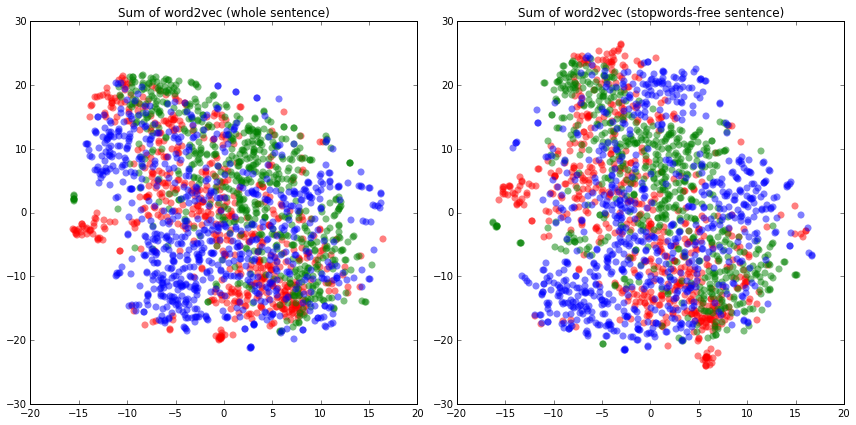

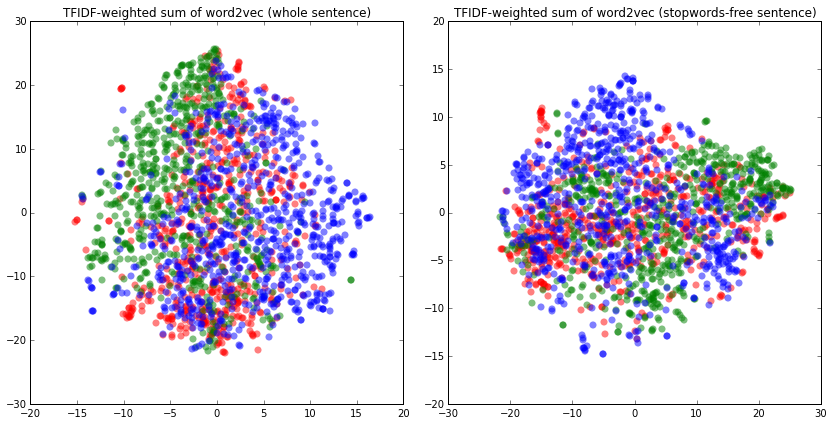

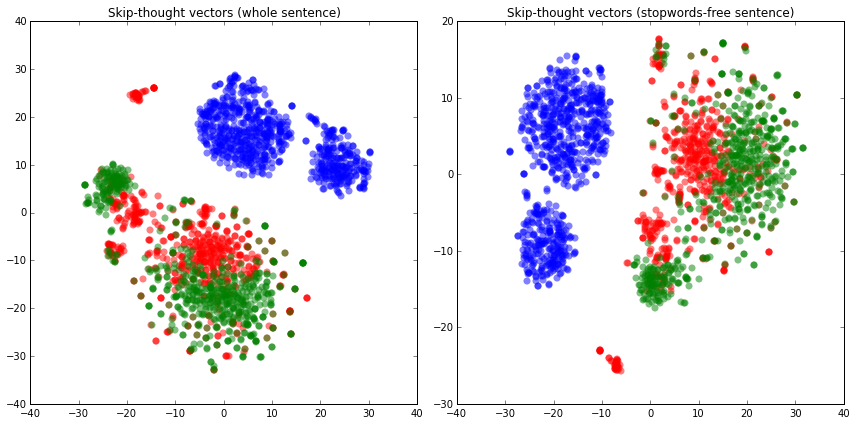

In [37]:
plot_tsne(w2v_tsne, stop_w2v_tsne, title='Sum of word2vec', activate_tooltip=False)
plot_tsne(tfidf_w2v_tsne,stop_tfidf_w2v_tsne, title='TFIDF-weighted sum of word2vec', activate_tooltip=True)
plot_tsne(st_tsne, stop_st_tsne, title='Skip-thought vectors', activate_tooltip=True)